In [1]:
# All libraries for XGBoost


#Classic libraries
import pandas as pd
import numpy as np

# XGBoost library
import xgboost as xgb

# Split test and train set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#feature selection
from sklearn.feature_selection import SelectPercentile, chi2

# Libraries for graphics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'credit_risk_dataset.csv'
df = pd.read_csv(path, delimiter=',')
nrows, ncols = df.shape

print(f'The number of rows are {nrows} and the number of columns {ncols}')

The number of rows are 32581 and the number of columns 12


In [3]:
df.head() # This only shows the firts 5 rows

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [5]:
data = df.dropna(axis = 0)

#By observing max and minimum and by using general conscious, Outliers are removed.

data = data[data["person_age"]<=100]
data = data[data["person_emp_length"]<=100]
data = data[data["person_income"]<= 4000000]


In [6]:
n_data = pd.get_dummies(data=data,columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
n_data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


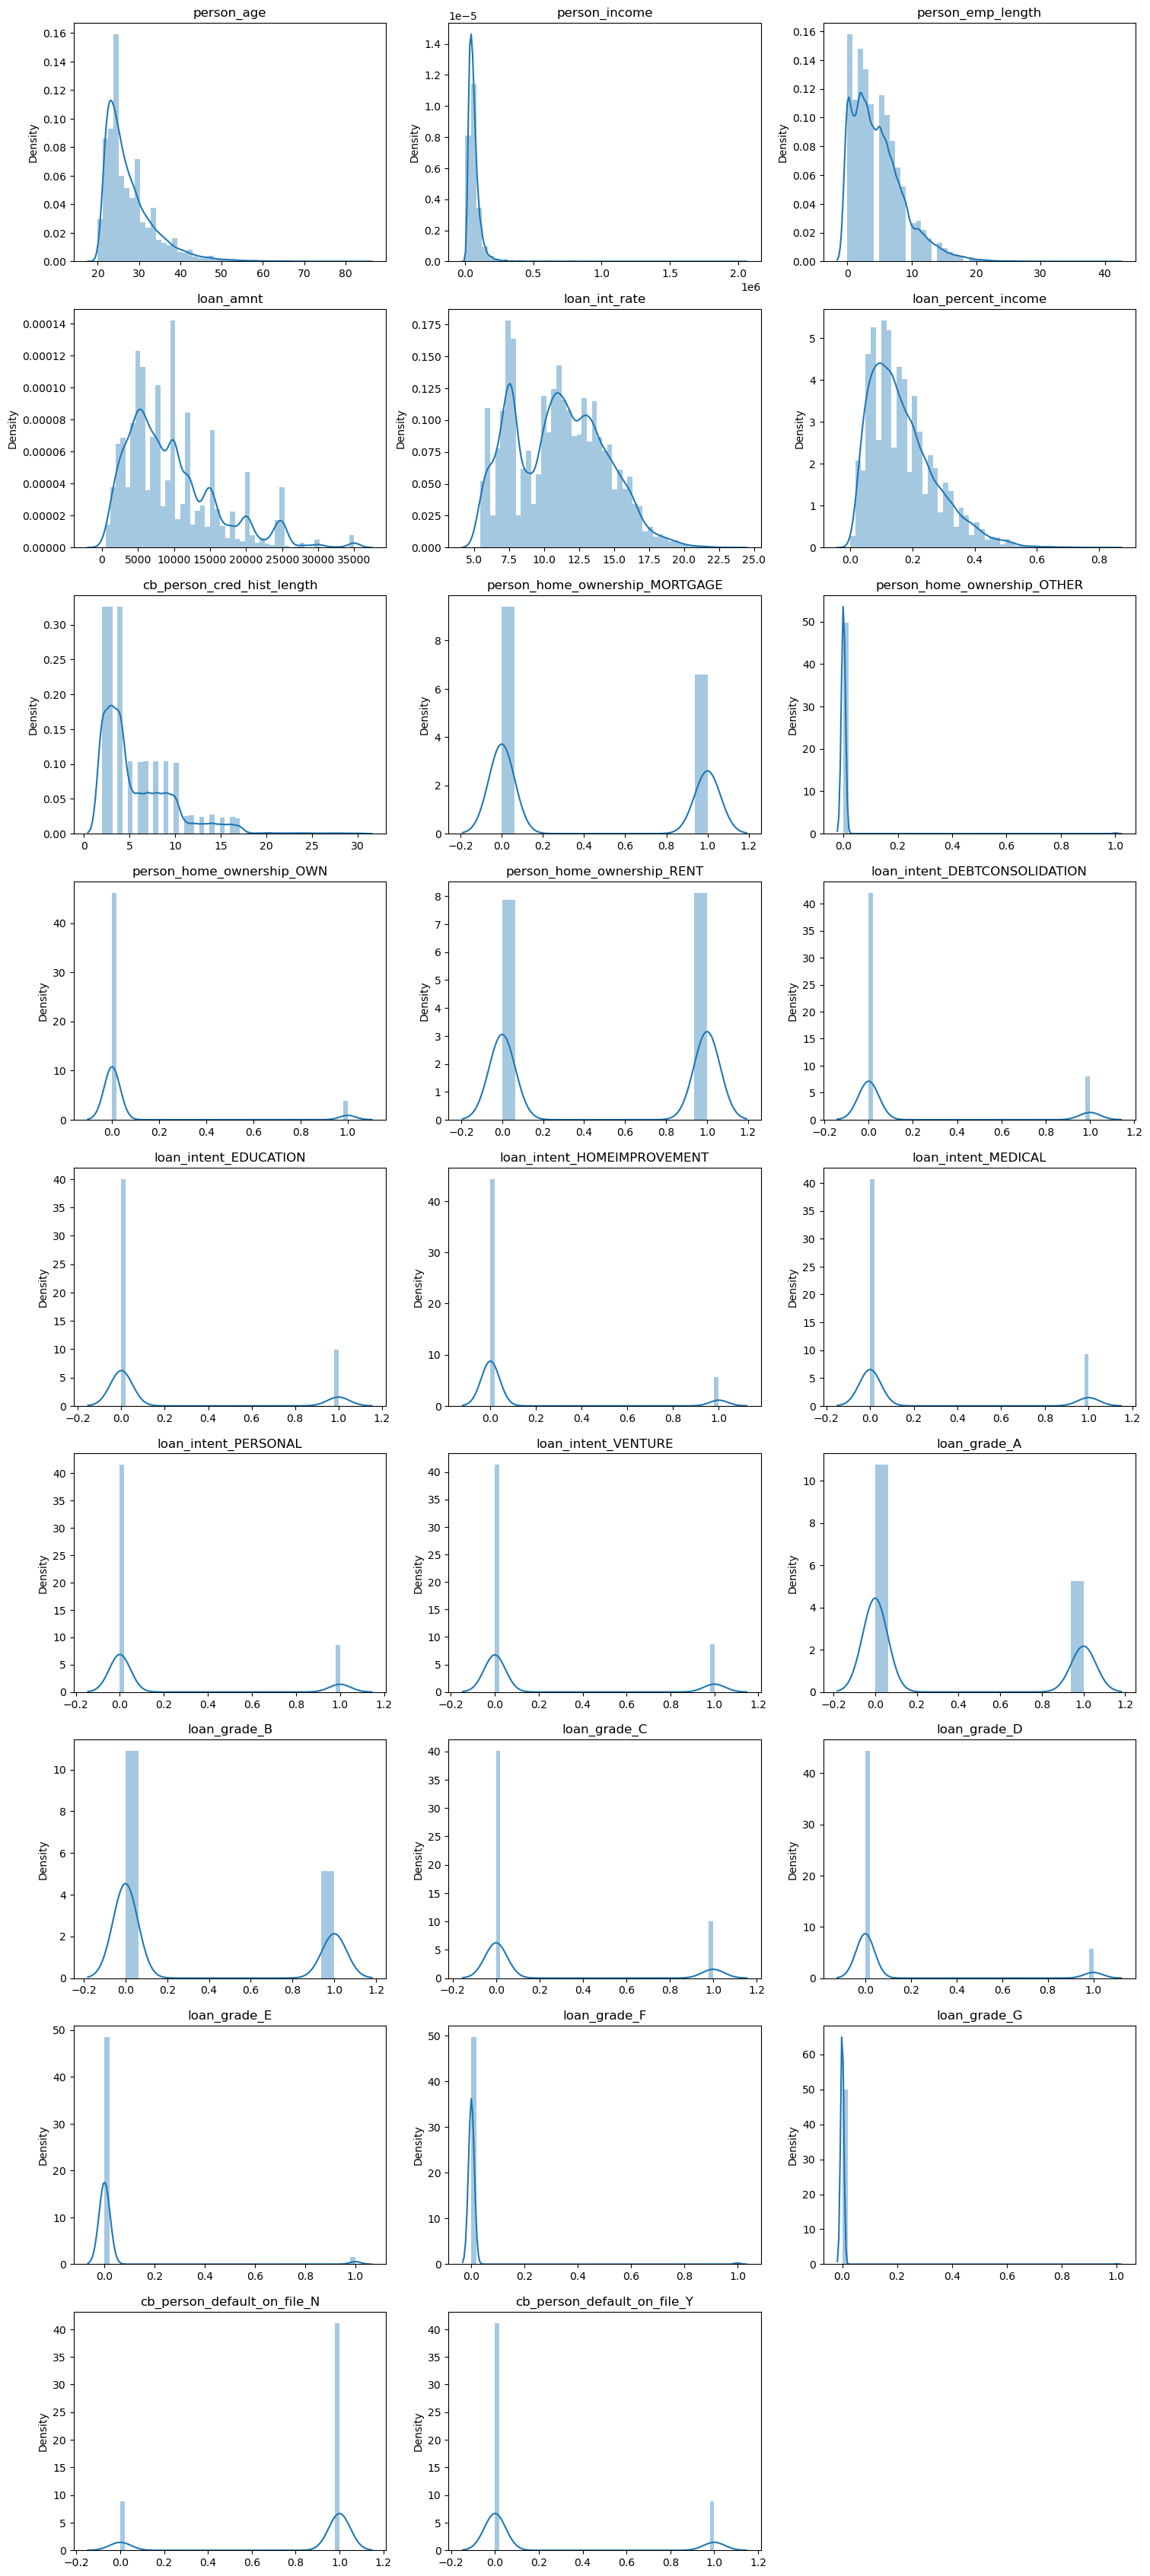

In [7]:
y=n_data['loan_status']
x=n_data.drop('loan_status',axis=1)

import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(18, 48))
for i in enumerate(x):
    plt.subplot(10, 3, i[0]+1)
    sns.distplot(df , x = n_data[i[1]])
    plt.title(i[1])

In [8]:
# split the datasers X, Y

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size=0.2)

params = {'booster':'gbtree',
          'n_estimators':1600,
          'objective':'reg:linear',
          'max_depth':4,
          'learning_rate':0.005    
}

print(x_test.shape)

(5727, 26)


In [9]:
#XG Boost Model
reg = xgb.XGBClassifier(**params)
reg.fit(x_train,y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=200)


[13:16:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49833	validation_1-rmse:0.49831
[200]	validation_0-rmse:0.31830	validation_1-rmse:0.31528
[400]	validation_0-rmse:0.27558	validation_1-rmse:0.27284
[600]	validation_0-rmse:0.26272	validation_1-rmse:0.26092
[800]	validation_0-rmse:0.25770	validation_1-rmse:0.25661
[1000]	validation_0-rmse:0.25436	validation_1-rmse:0.25395
[1200]	validation_0-rmse:0.25117	validation_1-rmse:0.25141
[1400]	validation_0-rmse:0.24921	validation_1-rmse:0.25005
[1599]	validation_0-rmse:0.24747	validation_1-rmse:0.24880


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1600, n_jobs=None, num_parallel_tree=None,
              objective='reg:linear', predictor=None, ...)

In [10]:
predsX = reg.predict(x_test)
preds_probX = reg.predict_proba(x_test)

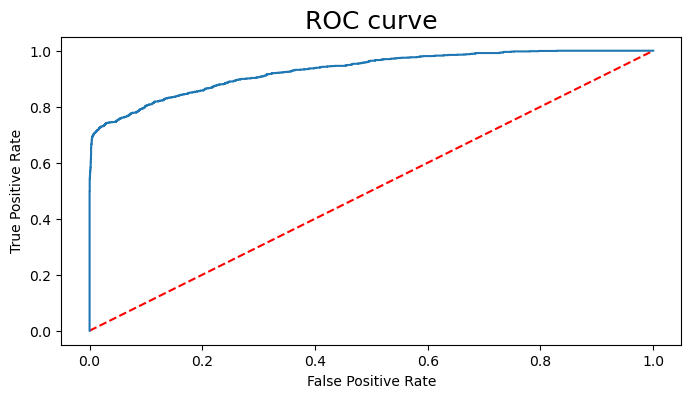

In [23]:
#Roc Curve

fig = plt.figure(figsize=(8,4))
plt.plot([0, 1], [0, 1],'r--')

probsxgb = preds_probX[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsxgb)
aucxgb = roc_auc_score(y_test, probsxgb)

plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(aucxgb,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
#plt.rcParams['axes.titlesize'] = 18
plt.show
plt.savefig('ROC curve', dpi=300)

# Feature Importance

<Figure size 200x800 with 0 Axes>

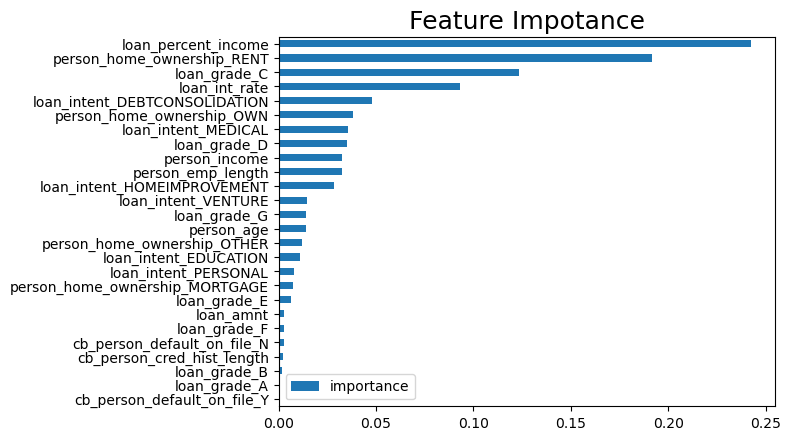

In [31]:
plt.figure (figsize = (2,8))

fi = pd.DataFrame(data = reg.feature_importances_,
                 index = reg.feature_names_in_,
                 columns = ['importance'])

fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Impotance')

plt.savefig('Feature Importance', dpi = 150)

In [13]:
# Score
from sklearn.metrics import accuracy_score
test_score = accuracy_score(predsX,y_test)

test_score*100

93.17269076305222

In [14]:
print('XG boost tree','\n', classification_report(y_test, reg.predict(x_test)))

XG boost tree 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4525
           1       0.96      0.70      0.81      1202

    accuracy                           0.93      5727
   macro avg       0.95      0.85      0.88      5727
weighted avg       0.93      0.93      0.93      5727

